In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from scipy.io import mmread
import scipy
from pprint import pprint
from sklearn.preprocessing import normalize
from ConfigParser import SafeConfigParser
import numpy as np
import time

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
from eval_util import *

universal_dir = 'en_lda'
translation_dir = 'en_lda'
config = '/home/ellery/wikimedia/missing_articles/missing_articles.ini'

cp = SafeConfigParser()
cp.read(config)

universal_base_dir = os.path.join(cp.get('general', 'local_data_dir'), universal_dir)
universal_hadoop_base_dir = os.path.join(cp.get('general', 'hadoop_data_dir'), universal_dir)

translation_base_dir = os.path.join(cp.get('general', 'local_data_dir'), translation_dir)
translation_hadoop_base_dir = os.path.join(cp.get('general', 'hadoop_data_dir'), translation_dir)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# only when doing translation
if universal_dir != translation_dir:
    translation_dict_file = os.path.join(translation_base_dir, cp.get('missing', 'ranked_missing_items'))
    id2sname, id2importance = get_translation_maps(translation_dict_file)

In [4]:
universal_dict_file = os.path.join(universal_base_dir, cp.get('LDA', 'article2index'))
id2index, index2id, id2uname = get_universal_maps(universal_dict_file)

In [5]:
mm_file = os.path.join(universal_base_dir, cp.get('LDA', 'doc2topic'))
f = open(mm_file)
M = mmread(f).tocsr()
M = normalize(M, norm='l2', axis=1)

In [6]:
rdata = {}
rdata['MI'] = M
if universal_dir == translation_dir:
    rdata['MR'] = M 
else:
    rdata['MR'] = reduce_and_reweight(M, id2importance, id2index, index2id)
rdata['id2index'] = id2index
rdata['index2id'] = index2id 
rdata['id2uname'] = id2uname 
rdata['item_target_importance'] = None 
rdata['num_to_rank'] = 10000
rdata['min_score'] = 0.5
rdata['get_interest_vector'] = get_weighted_average_interest_vector 

In [7]:
m = 3
k = 2
l = 1
n = 200
time1 = time.time()
contribution_file = os.path.join(translation_base_dir, cp.get('eval', 'train'))  
print recommend_and_eval_all(contribution_iter(contribution_file, k, l, m), rdata, n, verbose = False)
time2 = time.time()
print (time2-time1)   

MAP: 0.012723 MFTIR: 0.320000 MRL: 9485.840000
MAP: 0.006580 MFTIR: 0.260000 MRL: 9585.145000
Evaluated 200 editors
MAP: 0.006580 MFTIR: 0.260000 MRL: 9585.145000
[0.012722751745584482, 0.0065802344712217785]
26.504019022


In [60]:
sum(1 for _ in contribution_iter(contribution_file, k, l, 8))

258477

In [61]:
(258477 *0.15) / (60*60)

10.769874999999999

In [16]:
import multiprocessing
import time
import copy

args = {}
args['m'] = 9
args['l'] = 1
args['n'] = 20000

args_list = []

ks = [1, 4, 8]
interest_functions = [get_average_interest_vector, get_weighted_average_interest_vector, get_weighted_mediod_interest_vector]

for k in ks:
    for f in interest_functions:
        argsd = copy.deepcopy(args)
        argsd['k'] = k
        argsd['get_interest_vector'] = f
        args_list.append(argsd)


def mp_worker(args):
    m = args['m']
    k = args['k']
    l = args['l']
    n = args['n']
    f = args['get_interest_vector']
    rdata['get_interest_vector'] = f
    MAPs = recommend_and_eval_all(contribution_iter(contribution_file, k, l, m), rdata, n, verbose = False)
    res = {}
    res['k'] = k
    res['f'] = f.__name__
    res['MAPs'] = MAPs
    return res


    
p = multiprocessing.Pool(9)
time1 = time.time()
results = p.map(mp_worker, args_list)
time2 = time.time()
print 'Time: ', (time2-time1)   


MAP: 0.000261 MFTIR: 0.240000 MRL: 8538.990000
MAP: 0.000511 MFTIR: 0.180000 MRL: 9740.800000
MAP: 0.000253 MFTIR: 0.230000 MRL: 8535.130000
MAP: 0.000791 MFTIR: 0.170000 MRL: 9803.160000
MAP: 0.000791 MFTIR: 0.170000 MRL: 9803.160000
MAP: 0.000476 MFTIR: 0.210000 MRL: 8446.700000
MAP: 0.000791 MFTIR: 0.170000 MRL: 9803.160000
MAP: 0.000646 MFTIR: 0.230000 MRL: 9048.340000
MAP: 0.000634 MFTIR: 0.180000 MRL: 9800.030000
MAP: 0.001775 MFTIR: 0.225000 MRL: 8620.750000MAP: 0.002465 MFTIR: 0.175000 MRL: 9671.240000MAP: 0.001898 MFTIR: 0.230000 MRL: 8643.375000MAP: 0.002195 MFTIR: 0.190000 MRL: 9595.250000MAP: 0.002195 MFTIR: 0.190000 MRL: 9595.250000MAP: 0.002682 MFTIR: 0.210000 MRL: 8596.825000MAP: 0.002195 MFTIR: 0.190000 MRL: 9595.250000MAP: 0.002193 MFTIR: 0.235000 MRL: 9046.590000MAP: 0.003720 MFTIR: 0.180000 MRL: 9682.505000








MAP: 0.001547 MFTIR: 0.230000 MRL: 8738.880000MAP: 0.002297 MFTIR: 0.183333 MRL: 9713.633333MAP: 0.001550 MFTIR: 0.233333 MRL: 8773.536667MAP: 0.004504 MF

ValueError: attempt to get argmin of an empty sequence






MAP: 0.003690 MFTIR: 0.219375 MRL: 8383.840625MAP: 0.002920 MFTIR: 0.177500 MRL: 9666.186250MAP: 0.003826 MFTIR: 0.217500 MRL: 8365.833125MAP: 0.004430 MFTIR: 0.176875 MRL: 9574.730000MAP: 0.004430 MFTIR: 0.176875 MRL: 9574.730000MAP: 0.004309 MFTIR: 0.209375 MRL: 8202.902500MAP: 0.004430 MFTIR: 0.176875 MRL: 9574.730000MAP: 0.003746 MFTIR: 0.216875 MRL: 8784.259375MAP: 0.003605 MFTIR: 0.176875 MRL: 9618.197500








MAP: 0.003944 MFTIR: 0.220588 MRL: 8379.823529MAP: 0.003262 MFTIR: 0.178235 MRL: 9655.755294MAP: 0.004030 MFTIR: 0.218824 MRL: 8346.218824MAP: 0.004231 MFTIR: 0.176471 MRL: 9571.407059MAP: 0.004231 MFTIR: 0.176471 MRL: 9571.407059MAP: 0.004762 MFTIR: 0.207647 MRL: 8195.107059MAP: 0.004231 MFTIR: 0.176471 MRL: 9571.407059MAP: 0.004229 MFTIR: 0.214706 MRL: 8751.618824MAP: 0.003933 MFTIR: 0.175882 MRL: 9587.875882








MAP: 0.003804 MFTIR: 0.222222 MRL: 8384.305556MAP: 0.003117 MFTIR: 0.180556 MRL: 9646.296111MAP: 0.003905 MFTIR: 0.219444 MRL: 8351.875556MAP: 0.0040

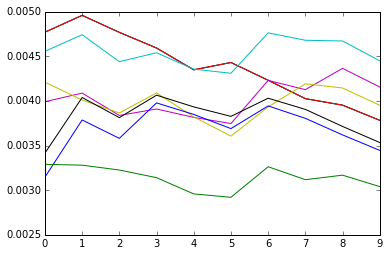

In [15]:
import matplotlib.pyplot as plt 
fig = plt.figure(figsize=(18,8))
for d in results:
    plt.plot(d['MAPs'][-10:])
savefig('trajectories.pdf')

In [ ]:
import psutil, os

def kill_proc_tree(pid, including_parent=True):    
    parent = psutil.Process(pid)
    for child in parent.get_children(recursive=True):
        child.kill()
    if including_parent:
        parent.kill()

me = os.getpid()
kill_proc_tree(me, including_parent=False)

In [10]:
pprint(results)

[{'MAPs': [0.0007911730234549736,
           0.0021953875049764648,
           0.00450379569690353,
           0.004937917205257998,
           0.005485379163271203,
           0.004849792360574813,
           0.005251667758253155,
           0.005021838242464138,
           0.005064728331838971,
           0.005121857084293347,
           0.00476919857391021,
           0.004958016988008095,
           0.004767466582264466,
           0.004592272647611552,
           0.004347937814904008,
           0.004429918588346863,
           0.004230969272680254,
           0.004025063756998968,
           0.003952208889454069,
           0.003782077864398502],
  'f': 'get_average_interest_vector',
  'k': 1},
 {'MAPs': [0.0007911730234549736,
           0.0021953875049764648,
           0.00450379569690353,
           0.004937917205257998,
           0.005485379163271203,
           0.004849792360574813,
           0.005251667758253155,
           0.005021838242464138,
           0.005064728331

#Timing Experiments

In [45]:
chunk_size = 100
num_to_rank = 1000
k=4
l=1


args = []

contribution_file = os.path.join(translation_base_dir, cp.get('eval', 'train'))  
iterator = contribution_iter(contribution_file, k, l)

time1 = time.time()
contributions_list = [next(iterator) for i in range(chunk_size)]
time2 = time.time()
print (time2-time1)

0.0827407836914


In [46]:
# get interest vector
time1 = time.time()
I = np.array([get_average_interest_vector(M, id2index, None, t[0]) for t in contributions_list]).transpose()
time2 = time.time()
print (time2-time1)

0.100946903229


In [47]:
# Get Scores
time1 = time.time()
#scores = M.dot(scipy.sparse.csr_matrix(I))
scores = M.dot(I)
time2 = time.time()
print (time2-time1)

6.42592716217


In [48]:
time1 = time.time()
for column in scores.T:
    non_zero_indices = np.where(column > 0.4)
    non_zero_index2id = index2id[non_zero_indices]
    ranking = np.argsort(-column[non_zero_indices])[:num_to_rank]
    resutl = zip(non_zero_index2id[ranking], scores[ranking])

time2 = time.time()
print (time2-time1)   

7.70238804817


In [ ]:
from itertools import izip
def sort_coo(m):
    tuples = izip(m.row, m.col, m.data)
    return sorted(tuples, key=lambda x: (x[0], x[2]))
time1 = time.time()
r = sort_coo(scores)
print (time2-time1)

In [25]:
time1 = time.time()
scores = scipy.sparse.coo_matrix(scores)
time2 = time.time()
print (time2-time1)

8.82704210281


In [17]:
type(scores)

numpy.ndarray

In [15]:
time1 = time.time()
ranking = np.argsort(-scores, kind = 'mergesort', axis = 0)[:num_to_rank, ]
time2 = time.time()
print (time2-time1)

8.91481494904


In [4]:
for i , line in enumerate(contribution_iter(contribution_file, k, l)):
    pass

In [5]:
i


258476

In [ ]:
eval_dict = collections.OrderedDict()
eval_dict['Bio'] = 'Q420|Q420'
eval_dict['vw'] = 'Q246 Q622618 Q697152 Q835078|Q247 Q2506880'
eval_dict['bio'] = 'Q7187 Q178694 Q7430 Q8066 Q37748 Q19088|Q39572 Q47263'
eval_dict['hesse'] = 'Q576493 Q2171354 Q860577|Q457289 Q217073'
eval_dict['herzog'] = 'Q1113073 Q688329 Q325662|Q695888'

for k, line in eval_dict.iteritems():
    print "\n\n###########   %s   ###############" % k
    #recommend(M, item_id2name, item_id2index, index2name, line, verbose = True)